In [152]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
import torchvision
from torchvision.models import vgg, resnet
from torch.utils.data import Dataset, DataLoader
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from glob import glob
import numpy as np
from pdb import set_trace
import cv2
from tqdm import tqdm_notebook
from tqdm import tqdm
%matplotlib inline

In [115]:
import yaml
import os
import random

## Read/Load data

In [116]:
sim_data = yaml.load(open("../data/ck_training_data/sim_data_annotations.yaml", "rb").read())

In [216]:
CLASS_LABEL_TO_INDEX = {
    "Red": 0,
    "Green": 1,
    "Yellow": 2, 
    "No_Light": 3
}

INDEX_TO_CLASS_LABEL = {
    0: "Red",
    1: "Green",
    2: "Yellow", 
    3: "No_Light"
}

In [217]:
def read_image_and_tl_color_for_rosbag(path_to_ros_data="../data/ros_bag_1"):
    images = []
    tl_colors = []
    
#     set_trace()
    for tl_color_path in glob(f"{path_to_ros_data}/*"):
        color = tl_color_path.split("/")[-1]
        for image_path in glob(f"{tl_color_path}/*"):
            images.append(mpimg.imread(image_path))
            tl_colors.append(CLASS_LABEL_TO_INDEX[color])
    return np.array(images), np.array(tl_colors)
    

In [218]:
def read_image_and_tl_color_for_ck(sim_data, path_to_sim_data="../data/ck_training_data"):
    images = []
    tl_colors = []
    for data in sim_data:
        annotations = data.get("annotations") 
        image_path = os.path.join(path_to_sim_data, data['filename'])
        images.append(mpimg.imread(image_path))
        if annotations == []:
            tl_colors.append(CLASS_LABEL_TO_INDEX["No_Light"])
        else:
            # assume all classes are the same
            tl_color = annotations[0]['class']
            tl_colors.append(CLASS_LABEL_TO_INDEX[tl_color])
    return np.array(images), np.array(tl_colors)

In [229]:
images, tl_colors = read_image_and_tl_color_for_rosbag()
images = [cv2.resize(image, (224, 224)) for image in images]

In [259]:
# Classify just red and green
tl_colors[tl_colors==2] = 0
tl_colors[tl_colors==3] = 1

Class is: Green


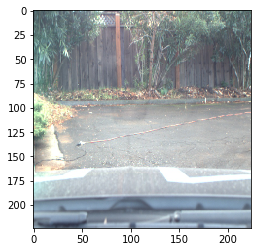

In [244]:
random_idx = random.choice(list(range(len(images))))
print(f"Class is: {INDEX_TO_CLASS_LABEL[tl_colors[random_idx]]}")
plt.imshow(images[random_idx])

In [245]:
# Convert to CHW for PyTorch
images = np.transpose(images, (0,3,1,2)).astype(np.float32)

## Split data

In [246]:
train_images, test_images, \
train_tl_colors, test_tl_colors = \
train_test_split(images, tl_colors, stratify=tl_colors, test_size=0.2)

In [247]:
Counter(train_tl_colors)

Counter({0: 1730, 1: 1623})

In [248]:
Counter(test_tl_colors)

Counter({0: 433, 1: 406})

## Create DataLoader

In [249]:
class TLDataset(Dataset):
    def __init__(self, images, tl_color=None):
        self.images = images
        self.tl_color = tl_color
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        ret = dict(images=images[i])
        if self.tl_color is not None:
            ret.update(dict(tl_color=self.tl_color[i]))
        return ret

In [250]:
train_dl = DataLoader(TLDataset(train_images, train_tl_colors), batch_size=32, shuffle=True)
test_dl = DataLoader(TLDataset(test_images, test_tl_colors), batch_size=32, shuffle=False)

## Setup Training Loop

In [251]:
def cudarize(tensors):
    if torch.cuda.is_available():
        return tensors.cuda()
    else:
        return tensors

In [256]:
model = cudarize(resnet.resnet18(num_classes=2))
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00003)

In [257]:
# for param in model.parameters():
#     param.requires_grad = False
    # Replace the last fully-connected layer
    # Parameters of newly constructed modules have requires_grad=True by default
# model.fc = nn.Linear(512, 4) # assuming that the fc7 layer has 512 neurons, otherwise change it 
# model.cuda()

In [258]:
def step(batch, optimizer, is_train):
    inp = cudarize(Variable(batch['images']))
    target = cudarize(Variable(batch['tl_color']))
    pred = F.log_softmax(model(inp), dim=1)
    loss = criterion(pred, target)
    if is_train: 
        optimizer.zero_grad()
        weights = cudarize(Variable(torch.ones_like(loss).cpu().data))
#         if target.data[0] == 3:
#             weights * 0.25
        torch.autograd.backward(loss, weights)
        optimizer.step()
    return pred, target, loss
from collections import defaultdict
# train_losses = defaultdict(list)
# val_losses = defaultdict(list)
train_losses = []
val_losses = []
for epoch in range(10):
    for batch in tqdm_notebook(train_dl):
        model.train()
        pred, target, loss = step(batch, optimizer, is_train=True) 
#         tqdm.write(f"Loss: {loss.data[0]}")
        train_losses.append(loss.data[0])
#         train_losses[target.data[0]].append(loss.data[0])
    for batch in tqdm_notebook(test_dl):
        model.eval()
        pred, target, loss = step(batch, optimizer, is_train=False) 
#         tqdm.write(f"Loss: {loss.data[0]}")
        val_losses.append(loss.data[0])
#         val_losses[target.data[0]].append(loss.data[0])
    print(f"Average train loss: {np.mean(train_losses)}")
    print(f"Average val loss: {np.mean(val_losses)}")
    train_losses = []
    val_losses = []

HBox(children=(IntProgress(value=0, max=105), HTML(value='')))

HBox(children=(IntProgress(value=0, max=27), HTML(value='')))


Average train loss: 0.7049898017020453
Average val loss: 0.6967723789038481


HBox(children=(IntProgress(value=0, max=105), HTML(value='')))

HBox(children=(IntProgress(value=0, max=27), HTML(value='')))


Average train loss: 0.658986572992234
Average val loss: 0.7380337891755281


HBox(children=(IntProgress(value=0, max=105), HTML(value='')))

HBox(children=(IntProgress(value=0, max=27), HTML(value='')))


Average train loss: 0.6323488698119208
Average val loss: 0.7218151114605091


HBox(children=(IntProgress(value=0, max=105), HTML(value='')))

HBox(children=(IntProgress(value=0, max=27), HTML(value='')))


Average train loss: 0.6014804289454505
Average val loss: 0.814354176874514


HBox(children=(IntProgress(value=0, max=105), HTML(value='')))

HBox(children=(IntProgress(value=0, max=27), HTML(value='')))


Average train loss: 0.5781456689039867
Average val loss: 0.7859729749185068


HBox(children=(IntProgress(value=0, max=105), HTML(value='')))

HBox(children=(IntProgress(value=0, max=27), HTML(value='')))


Average train loss: 0.5690307438373565
Average val loss: 0.7431044600628041


HBox(children=(IntProgress(value=0, max=105), HTML(value='')))

HBox(children=(IntProgress(value=0, max=27), HTML(value='')))


Average train loss: 0.5544904453413827
Average val loss: 0.7602601890210752


HBox(children=(IntProgress(value=0, max=105), HTML(value='')))

HBox(children=(IntProgress(value=0, max=27), HTML(value='')))


Average train loss: 0.545850962684268
Average val loss: 0.7537095590874001


HBox(children=(IntProgress(value=0, max=105), HTML(value='')))

HBox(children=(IntProgress(value=0, max=27), HTML(value='')))


Average train loss: 0.5387138971260615
Average val loss: 0.7726302985791806


HBox(children=(IntProgress(value=0, max=105), HTML(value='')))

HBox(children=(IntProgress(value=0, max=27), HTML(value='')))


Average train loss: 0.5289366021042778
Average val loss: 0.7993132924592053


In [141]:
train_losses

defaultdict(list,
            {0: [0.9846715927124023,
              0.28481435775756836,
              0.16005802154541016,
              0.10676431655883789,
              0.11007356643676758,
              1.0953903198242188,
              0.2482013702392578,
              0.11841297149658203,
              0.7650742530822754,
              0.20058202743530273,
              0.1257925033569336,
              0.29817628860473633,
              0.11554813385009766,
              0.10046052932739258,
              0.20431280136108398,
              0.31169605255126953,
              0.2601027488708496,
              0.09946346282958984,
              0.16294193267822266,
              0.1855149269104004,
              0.1561741828918457,
              0.1763629913330078,
              0.1605997085571289,
              0.7192907333374023,
              2.4351959228515625,
              0.5019993782043457,
              0.19376564025878906,
              1.0909929275512695,
             

In [142]:
val_losses

defaultdict(list,
            {0: [2.684863328933716,
              2.6217427253723145,
              1.2981457710266113,
              1.539902925491333,
              1.4809341430664062,
              4.6073713302612305,
              4.6029229164123535,
              4.526050567626953,
              4.808497905731201],
             1: [4.158532619476318,
              5.907527446746826,
              1.7463593482971191,
              0.7347359657287598,
              1.5314793586730957,
              1.836334466934204,
              3.72890043258667,
              4.5090651512146,
              6.794762134552002],
             2: [1.7413825988769531,
              1.413710594177246,
              2.5726943016052246,
              3.088177442550659,
              5.198535442352295,
              2.266847610473633],
             3: [0.2697319984436035,
              0.3433241844177246,
              0.3433241844177246,
              0.3899083137512207,
              0.0750856399536132

In [73]:
target

Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]